In [6]:
import numpy as np 
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt 
import itertools
import scprep
from sklearn.metrics import adjusted_rand_score as ari
from anticor_features.anticor_features import get_anti_cor_genes
import singleCellHaystack as hs
import giniclust3 as gc
from SEMITONES.cell_selection import from_knn_dist
from SEMITONES.enrichment_scoring import calculate_escores
from SEMITONES.enrichment_scoring import permute
from SEMITONES.enrichment_scoring import sig_interval
from SEMITONES.support_funcs import pairwise_similarities
from SEMITONES.support_funcs import sig_dictionary
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics import roc_curve, auc
import re
from collections import defaultdict

In [3]:
def extract_gene_category(gene_name):
    match = re.match(r'g(\w+)_', gene_name)
    if match:
        return match.group(1)
    return "Unknown"

In [2]:
adata_test = sc.read_h5ad('sc_simulator/sim_data/adata/adata_11.h5ad')

In [7]:
gene_categories = [extract_gene_category(gene) for gene in adata_test.var_names]
gene_dict = defaultdict(list)
for category, gene_name in zip(gene_categories, adata_test.var_names):
    gene_dict[category].append(gene_name)

In [9]:
def dimension_reduce(adata):
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20)
    return adata

In [10]:
if __name__ == "__main__":
    adata_test.var_names_make_unique()

    # anticor
    adata_anti = adata_test.copy()
    sc.pp.normalize_total(adata_anti)
    print('anti')
    anti_cor_table = get_anti_cor_genes(
        adata_anti.X.T,
        adata_anti.var.index.tolist(),
        species="hsapiens",
        pre_remove_pathways=[],
        # FPR=0.0002,
        # FDR=1/40
    )
    selected_table = anti_cor_table[anti_cor_table["selected"]==True]
    print(selected_table)

    adata_anti.var = pd.concat([adata_anti.var,anti_cor_table], axis=1)
    adata_anti.raw = adata_anti
    adata_anti = adata_anti[:, selected_table.index]

    # schaystack
    adata_hs = adata_test.copy()
    adata_hs.layers["counts"] = adata_hs.X.copy()
    sc.pp.normalize_total(adata_hs)
    sc.pp.log1p(adata_hs)

    adata_hs = dimension_reduce(adata_hs)
    res = hs.haystack(adata_hs, coord="X_pca")
    adata_hs = adata_hs[:,res.top_features(n=120)['gene'].tolist()].copy()

    # giniclust
    adata_tem = adata_test.copy()
    # sc.pp.log1p(adata_tem)
    gc.gini.calGini(adata_tem, min_gini_value=0.1, neighbors=3, p_value=0.05)
    adata_gini = adata_tem[:, np.where(adata_tem.var['gini'] == True)[0]].copy()


    # semitones
    adata_tem = adata_test.copy()
    adata_tem.layers["counts"] = adata_tem.X.copy()
    sc.pp.normalize_total(adata_tem)
    sc.pp.log1p(adata_tem)
    adata_tem = dimension_reduce(adata_tem)
    S = pairwise_kernels(adata_tem.obsm['X_pca'], metric="rbf", gamma=8.6e-4)  # pariwise similarities
    median = np.median(S, axis=0)
    start = int(np.argmin(median))

    dd_rcells = from_knn_dist(
        X=adata_tem.obsm['X_pca'],  # search in the 20 PC space
        n_ret=17,
        start=start,  # provide the least similar cell
        # metric="rbf",  # define the (dis)similarity metric
        metric_params={"gamma": 8.6e-4}
        )  # provide the gamma

    S = pairwise_similarities(
        adata_tem.obsm['X_pca'],
        query=dd_rcells,  
        # metric="rbf",  # metric as in notebook 1
        metric_params={"gamma": 8.6e-4}
        )
    
    escores = calculate_escores(adata_tem.X, query=dd_rcells, S=S)
    P = permute(adata_test.X)
    pscores = calculate_escores(P, query=dd_rcells, S=S)
    interval = sig_interval(pscores, n_sds=8)
    sigdict = sig_dictionary(escores, interval)
    subset = list({x for v in sigdict.values() for x in v})
    adata_semi = adata_test[:, subset].copy()

    adatas = [adata_anti, adata_gini, adata_hs, adata_semi]


anti
found 3806.104178688 free Gb in /tmp
get_all_remove_genes
240 12
min_express_n 12
get_n_expressed
pre_remove_feature: 0
pre_remove_pathway: 0
pre_remove_low_express: 0
0  genes to remove out of  270
rewriting the filtered dataset
/tmp/exprs.hdf5
total_vars: 270
making the hdf5 spearman output file
/tmp/spearman.hdf5
get_the_spears
total_vars 270
	getting spearman correlation
empirically determined Cneg cutoff: -0.20355214500251737  for FPR of: 0.001
empirically determined Cpos cutoff: 0.22902129835969753  for FPR of: 0.001
get_real_spear
[0, 270]
working on 0 270 vs 0 270
	getting spearman correlation
            gene  pre_remove_feature  pre_remove_pathway  \
gRoot_1  gRoot_1               False               False   
gRoot_2  gRoot_2               False               False   
gRoot_3  gRoot_3               False               False   
gRoot_4  gRoot_4               False               False   
gRoot_7  gRoot_7               False               False   
...          ...          

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 26782.28it/s]


> calculating feature's CV ...
> selecting genes to randomize ...
> calculating randomized KLD ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 265.70it/s]


> calculating P values ...
> done.
Gene number is 270
Cell number is 240
Start enrichment scoring
Enrichment scoring complete
Start enrichment scoring
Enrichment scoring complete


In [25]:
methods = ['anti-correlation', 'giniclust3', 'schaystack', 'semitones']

sensitivity_results = {}

for index in range(len(methods)):
    sensitivity = []
    for category, gene_list in gene_dict.items():
        if category != 'Root':
            genes =  set(adatas[index].var_names)
            label = set(gene_list)

            tp = len(label & genes)
            num = len(gene_list)
            
            sensitivity.append(tp/num)
        else:
            all_genes = set(list(gene_dict.values())[0])
            genes = all_genes-set(adata_anti.var_names)
            label = set(gene_list)

            tp = len(label & genes)
            num = len(gene_list)
            
            sensitivity.append(tp/num)
        
    sensitivity_results[methods[index]] = sensitivity


In [26]:
categories = [cat for cat in gene_dict.keys() if cat != 'Root'] + ['Root']

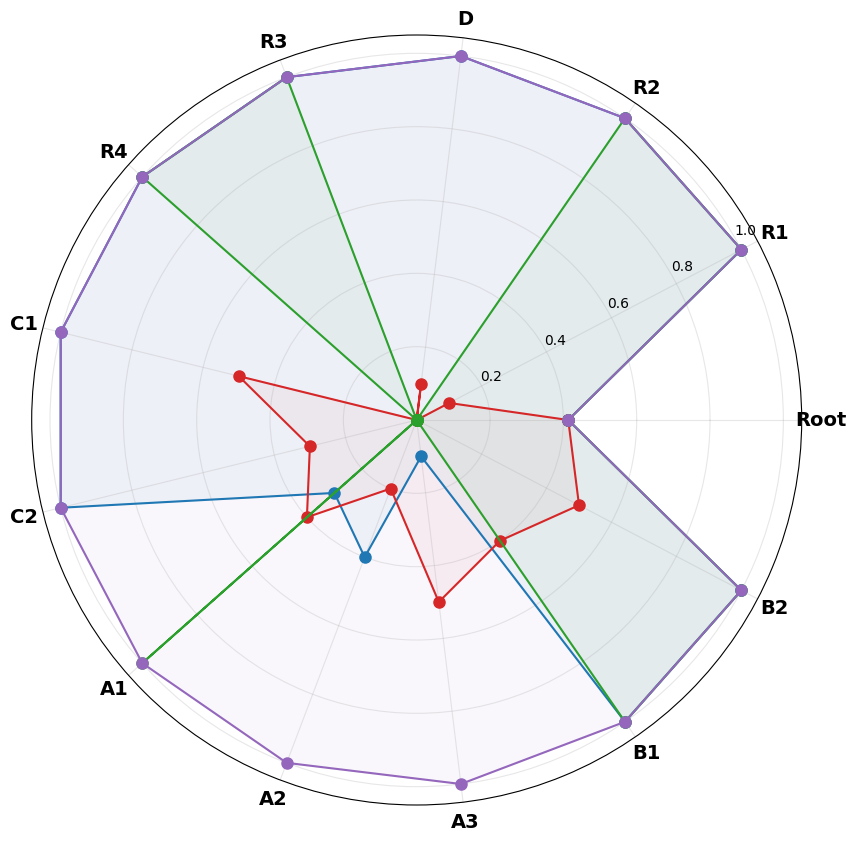

In [28]:
import matplotlib as mpl
import os


plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False



# 获取类别名称（排除Root）
categories = [cat for cat in gene_dict.keys()] 

def create_sensitivity_radar_chart(sensitivity_results, categories):

    method_colors = ['#1f77b4', '#d62728', '#2ca02c', '#9467bd',] 
                     # '#ff7f0e', '#17becf', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']
    
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    for i, (method, sensitivities) in enumerate(sensitivity_results.items()):
        values = sensitivities + [sensitivities[0]]
        color = method_colors[i % len(method_colors)]
        
        ax.plot(angles, values, 'o-', linewidth=1.5, label=method, color=color, markersize=8)
        ax.fill(angles, values, alpha=0.05, color=color)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=14, fontweight='bold')
    
    ax.set_rlabel_position(30)


    
    ax.grid(alpha=0.3)

    plt.show()
    



create_sensitivity_radar_chart(sensitivity_results, categories)


In [23]:
for i, (method, sensitivities) in enumerate(sensitivity_results.items()):
    print(sensitivities)

[0.41333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.4, 0.1, 1.0, 1.0]
[0.41333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.4, 0.1, 1.0, 1.0]
[0.41333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.4, 0.1, 1.0, 1.0]
[0.41333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.4, 0.1, 1.0, 1.0]


In [24]:
sensitivity_results.items()

dict_items([('anti-correlation', [0.41333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.4, 0.1, 1.0, 1.0]), ('giniclust3', [0.41333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.4, 0.1, 1.0, 1.0]), ('schaystack', [0.41333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.4, 0.1, 1.0, 1.0]), ('semitones', [0.41333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.4, 0.1, 1.0, 1.0])])